# Sun et al. (2024)

The aim of this notebook is to replicate the plots obtained by [Sun et al. (2024)](https://arxiv.org/abs/2403.01842).

In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic

/u/fiza/conda-envs/auriga/lib/python3.7/site-packages/setuptools/_importlib.py:23: UserWarning: `importlib-metadata` version is incompatible with `setuptools`.
This problem is likely to be solved by installing an updated version of `importlib-metadata`.
  warnings.warn(msg)  # Ensure a descriptive message is shown.


In [2]:
from auriga.snapshot import Snapshot
from auriga.images import figure_setup
from auriga.settings import Settings
from auriga.parser import parse

In [31]:
figure_setup()
settings = Settings()

In [61]:
def read_data(simulation: str) -> tuple:
    """
    This method returns data of interest for this analysis.

    Parameters
    ----------
    simulation : str
        The simulation to consider.

    Returns
    -------
    pd.DataFrame
        A data frame with the properties.
    """

    settings = Settings()

    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.tag_particles_by_region(
        disc_std_circ=settings.disc_std_circ,
        disc_min_circ=settings.disc_min_circ,
        cold_disc_delta_circ=settings.cold_disc_delta_circ,
        bulge_max_specific_energy=settings.bulge_max_specific_energy)
    s.add_metal_abundance(of="Fe", to='H')
    s.add_metal_abundance(of='O', to="Fe")
    s.add_metal_abundance(of="Mg", to="Fe")
    s.add_metal_abundance(of="Si", to="Fe")

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    df = pd.DataFrame()
    df["CylindricalRadius_ckpc"] = s.rho[is_real_star & is_main_obj]
    df["zPos_ckpc"] = s.pos[is_real_star & is_main_obj, 2]
    df["zVel_km/s"] = s.vel[is_real_star & is_main_obj, 2]
    df["phiVel_km/s"] = s.v_phi[is_real_star & is_main_obj]
    df["VelDispersion_km/s"] = np.linalg.norm(s.vel, axis=1)[
        is_real_star & is_main_obj]
    df["RegionTag"] = s.region_tag[is_real_star & is_main_obj]
    
    df["[Fe/H]"] = s.metal_abundance[f"Fe/H"][is_real_star & is_main_obj]
    df["[O/Fe]"] = s.metal_abundance[f"O/Fe"][is_real_star & is_main_obj]

    abunds = np.zeros(((is_real_star & is_main_obj).sum(), 3))
    abunds[:, 0] = s.metal_abundance[f"O/Fe"][is_real_star & is_main_obj]
    abunds[:, 1] = s.metal_abundance[f"Mg/Fe"][is_real_star & is_main_obj] \
        + 0.4
    abunds[:, 2] = s.metal_abundance[f"Si/Fe"][is_real_star & is_main_obj]
    df["[Alpha/Fe]"] = np.mean(abunds, axis=1)

    return df

In [62]:
df = read_data(simulation="au6_or_l4_s127")

In [63]:
df.dropna(inplace=True)

In [64]:
# Use the same restrictions as Sun et al. (2024)
df = df[(df["[Fe/H]"] >= -1.0) & (np.abs(df["zVel_km/s"]) <= 120.0)]

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1422816 entries, 0 to 1577892
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   CylindricalRadius_ckpc  1422816 non-null  float64
 1   zPos_ckpc               1422816 non-null  float64
 2   zVel_km/s               1422816 non-null  float64
 3   phiVel_km/s             1422816 non-null  float64
 4   VelDispersion_km/s      1422816 non-null  float64
 5   RegionTag               1422816 non-null  int8   
 6   [Fe/H]                  1422816 non-null  float64
 7   [O/Fe]                  1422816 non-null  float64
 8   [Alpha/Fe]              1422816 non-null  float64
dtypes: float64(8), int8(1)
memory usage: 99.1 MB


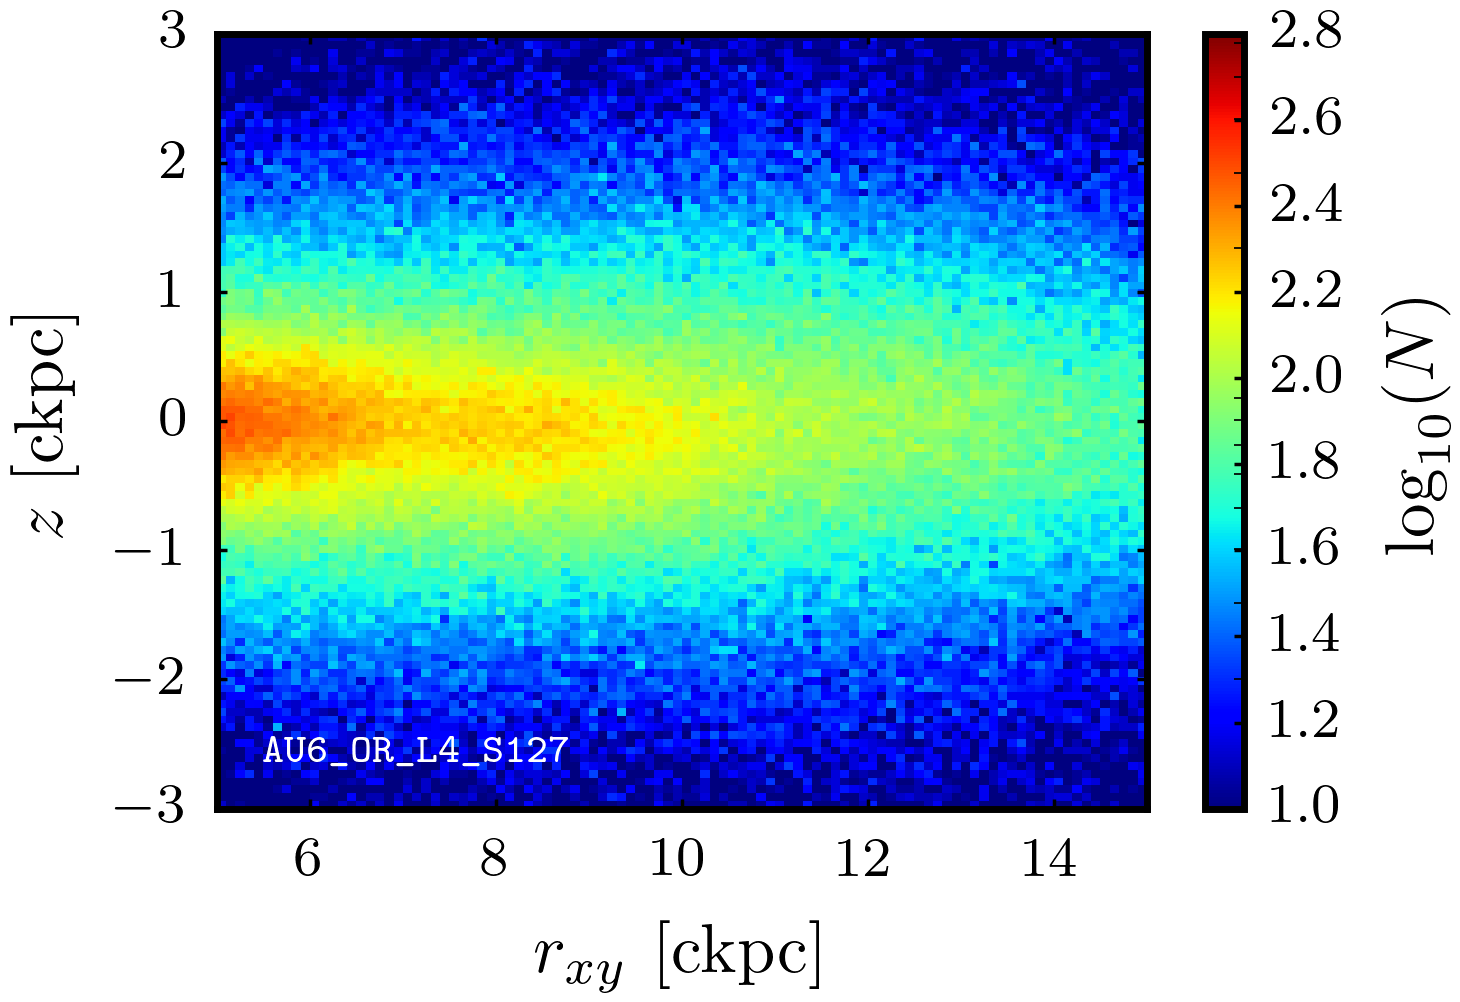

In [66]:
fig = plt.figure(figsize=(3.0, 2.0))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.tick_params(which='both', direction="in")
ax.set_xlim(5, 15)
ax.set_ylim(-3, 3)
ax.set_xlabel(r"$r_{xy}$ [ckpc]")
ax.set_ylabel(r"$z$ [ckpc]")
ax.label_outer()

_, _, _, im = ax.hist2d(
    x=df["CylindricalRadius_ckpc"][
        (df["RegionTag"] == 2) | (df["RegionTag"] == 3)],
    y=df["zPos_ckpc"][(df["RegionTag"] == 2) | (df["RegionTag"] == 3)],
    range=[ax.get_xlim(), ax.get_ylim()], bins=[100, 100],
    norm=mpl.colors.LogNorm(vmin=1E1, vmax=10**2.8))

ax.text(
    x=0.05, y=0.05, size=6.0, c="white",
    s=r"$\texttt{" + ("au6_or_l4_s127").upper() + "}$",
    ha="left", va="bottom", transform=ax.transAxes)

cbar = fig.colorbar(im, label=r"$\mathrm{log}_{10}(N)$")
cbar.set_ticks(ticks=(10**1.0, 10**1.2, 10**1.4, 10**1.6, 10**1.8,
                      10**2.0, 10**2.2, 10**2.4, 10**2.6, 10**2.8),
               labels=[1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8])

plt.show()

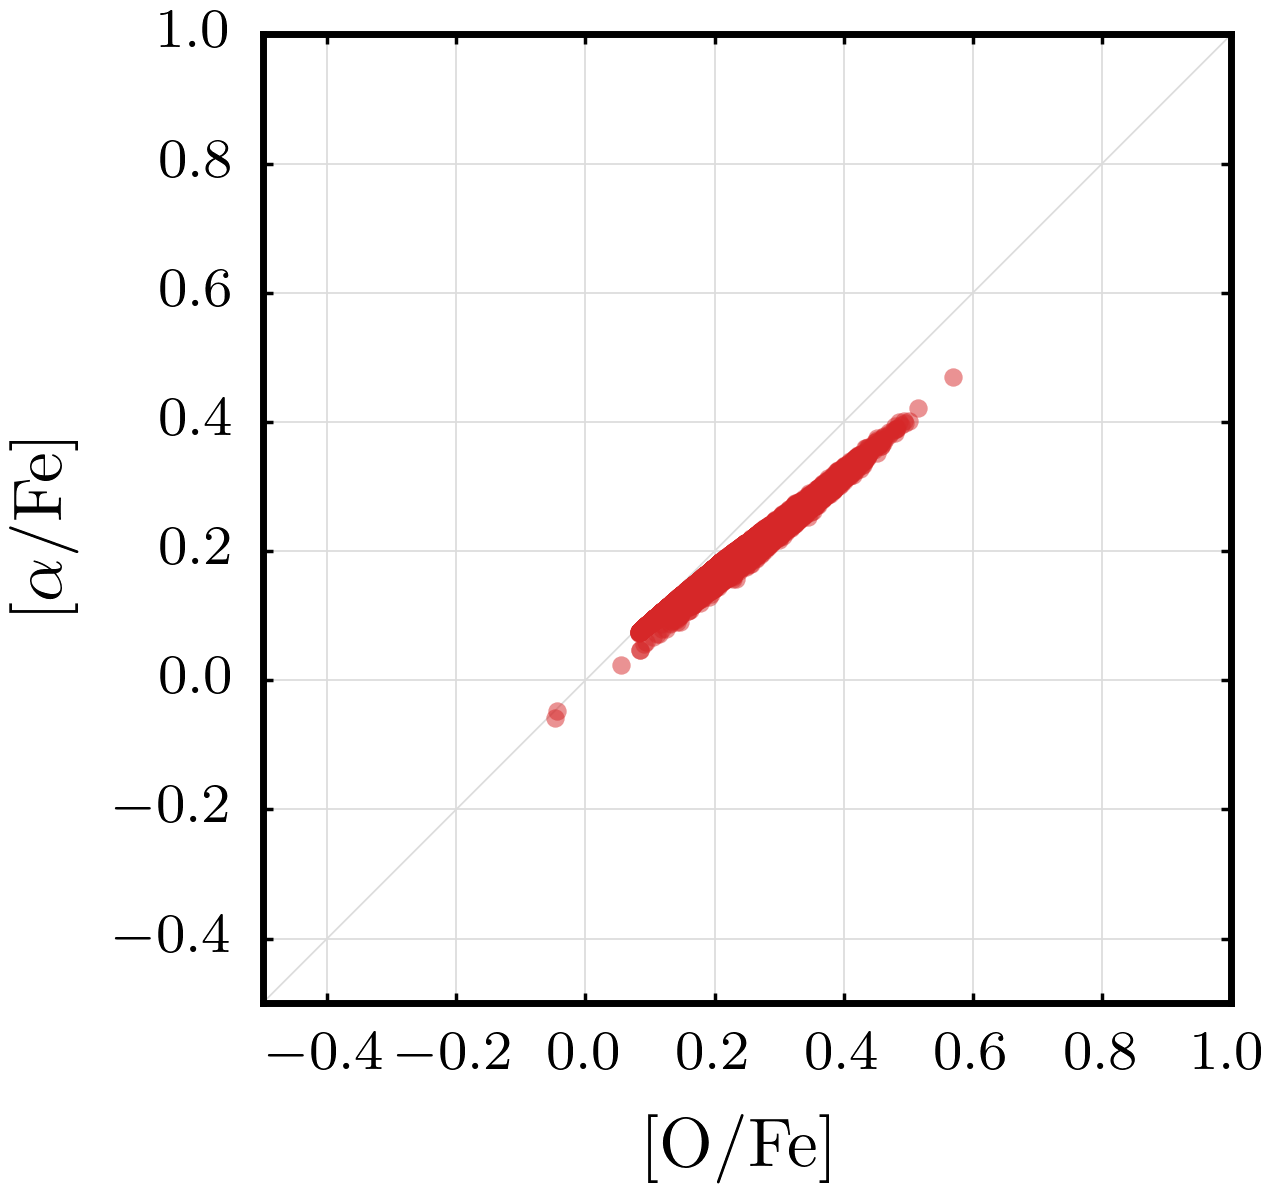

In [67]:
fig = plt.figure(figsize=(2.5, 2.5))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.set_axisbelow(True)
ax.grid(True, ls='-', lw=0.25, c="gainsboro")
ax.tick_params(which='both', direction="in")
ax.set_ylim(-0.5, 1)
ax.set_xlim(-0.5, 1)
ax.set_xlabel("[O/Fe]")
ax.set_ylabel(r"[$\alpha$/Fe]")
ax.label_outer()

ax.plot(ax.get_xlim(), ax.get_ylim(), c="gainsboro", lw=0.25)

ax.scatter(
    x=df["[O/Fe]"][(df["RegionTag"] == 2) | (df["RegionTag"] == 3)],
    y=df["[Alpha/Fe]"][(df["RegionTag"] == 2) | (df["RegionTag"] == 3)],
    alpha=0.5, c="tab:red", edgecolors=None, s=7.0, linewidths=0, zorder=10)

plt.show()

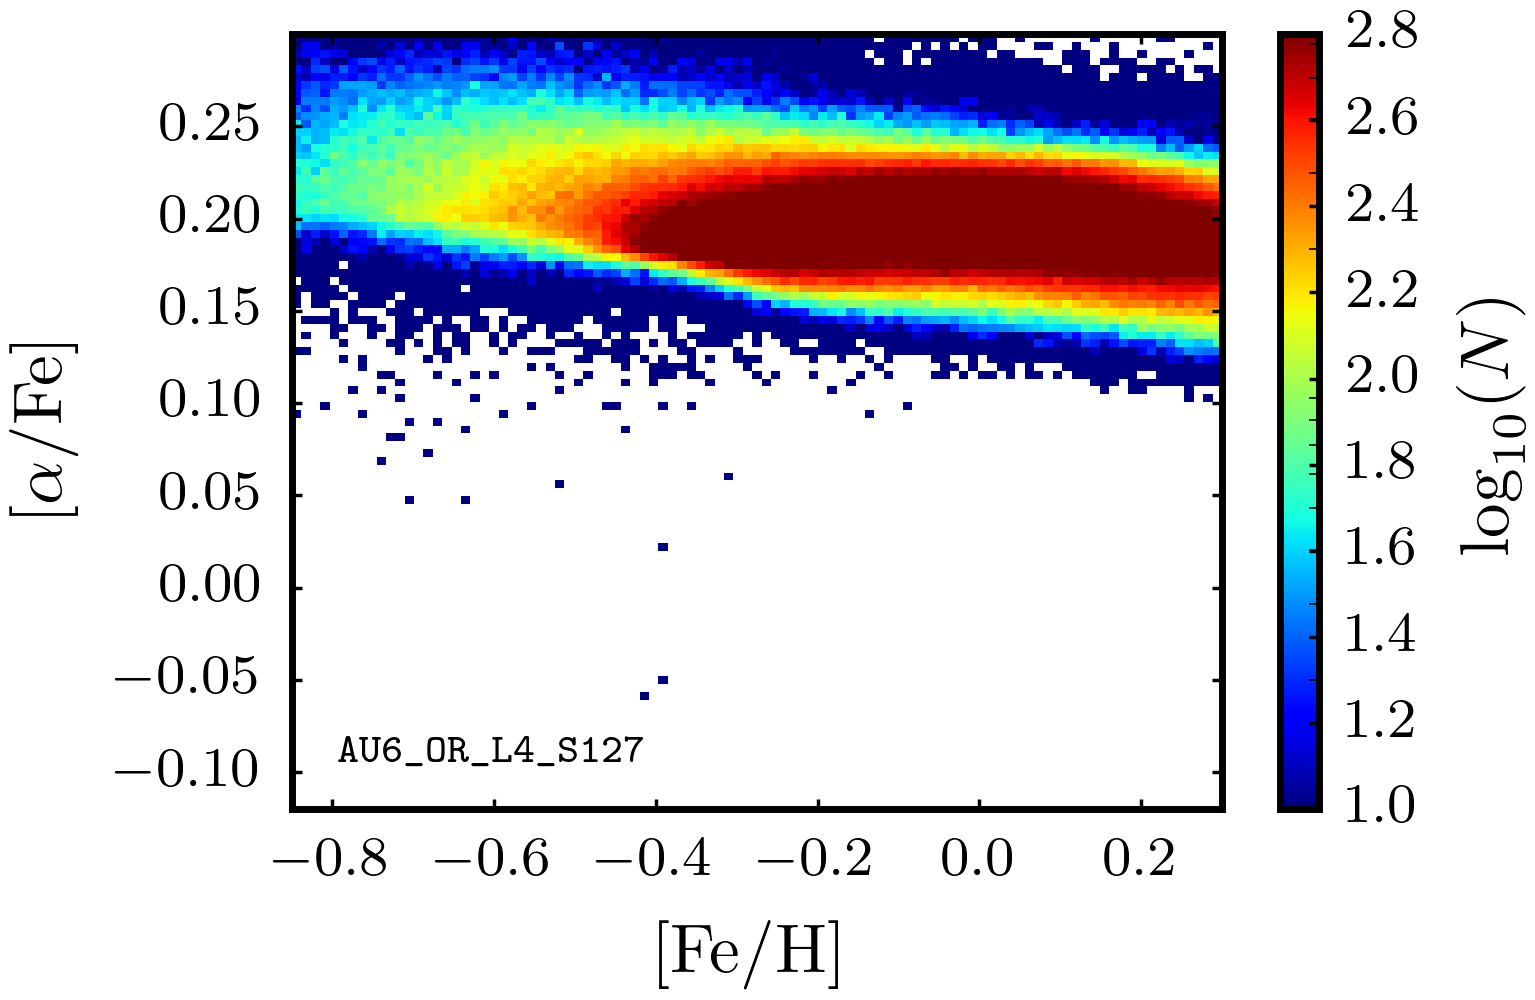

In [44]:
fig = plt.figure(figsize=(3.0, 2.0))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.tick_params(which='both', direction="in")
ax.set_xlim(-0.85, 0.3)
ax.set_ylim(-0.12, 0.3)
ax.set_xticks([-0.8, -0.6, -0.4, -0.2, 0, 0.2])
ax.set_yticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
ax.label_outer()

_, _, _, im = ax.hist2d(
    x=df["[Fe/H]"][(df["RegionTag"] == 2) | (df["RegionTag"] == 3)],
    y=df["[Alpha/Fe]"][(df["RegionTag"] == 2) | (df["RegionTag"] == 3)],
    bins=[np.linspace(-0.85, 0.3, 100), np.linspace(-0.12, 0.3, 100)],
    norm=mpl.colors.LogNorm(vmin=1E1, vmax=10**2.8))

ax.text(
    x=0.05, y=0.05, size=6.0, c="black",
    s=r"$\texttt{" + ("au6_or_l4_s127").upper() + "}$",
    ha="left", va="bottom", transform=ax.transAxes)

cbar = fig.colorbar(im, label=r"$\mathrm{log}_{10}(N)$")
cbar.set_ticks(ticks=(10**1.0, 10**1.2, 10**1.4, 10**1.6, 10**1.8,
                      10**2.0, 10**2.2, 10**2.4, 10**2.6, 10**2.8),
               labels=[1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8])

plt.show()

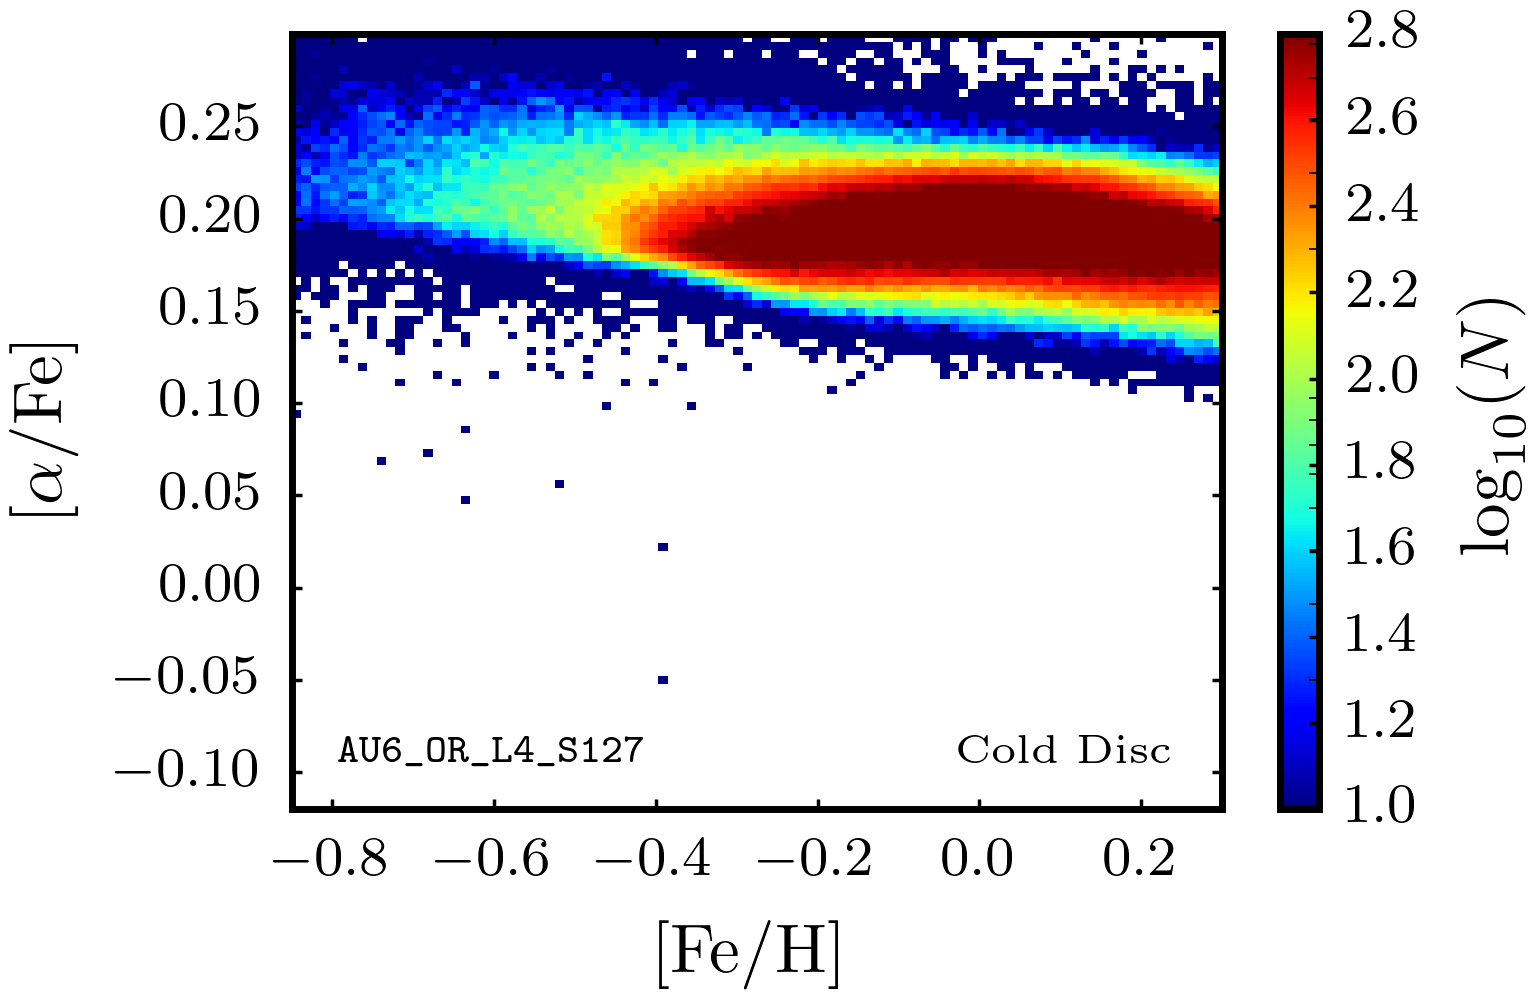

In [48]:
fig = plt.figure(figsize=(3.0, 2.0))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.tick_params(which='both', direction="in")
ax.set_xlim(-0.85, 0.3)
ax.set_ylim(-0.12, 0.3)
ax.set_xticks([-0.8, -0.6, -0.4, -0.2, 0, 0.2])
ax.set_yticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
ax.label_outer()

_, _, _, im = ax.hist2d(
    x=df["[Fe/H]"][(df["RegionTag"] == 2)],
    y=df["[Alpha/Fe]"][(df["RegionTag"] == 2)],
    bins=[np.linspace(-0.85, 0.3, 100), np.linspace(-0.12, 0.3, 100)],
    norm=mpl.colors.LogNorm(vmin=1E1, vmax=10**2.8))

ax.text(
    x=0.05, y=0.05, size=6.0, c="black",
    s=r"$\texttt{" + ("au6_or_l4_s127").upper() + "}$",
    ha="left", va="bottom", transform=ax.transAxes)
ax.text(
    x=0.95, y=0.05, size=6.0, c="black", s="Cold Disc",
    ha="right", va="bottom", transform=ax.transAxes)

cbar = fig.colorbar(im, label=r"$\mathrm{log}_{10}(N)$")
cbar.set_ticks(ticks=(10**1.0, 10**1.2, 10**1.4, 10**1.6, 10**1.8,
                      10**2.0, 10**2.2, 10**2.4, 10**2.6, 10**2.8),
               labels=[1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8])

plt.show()

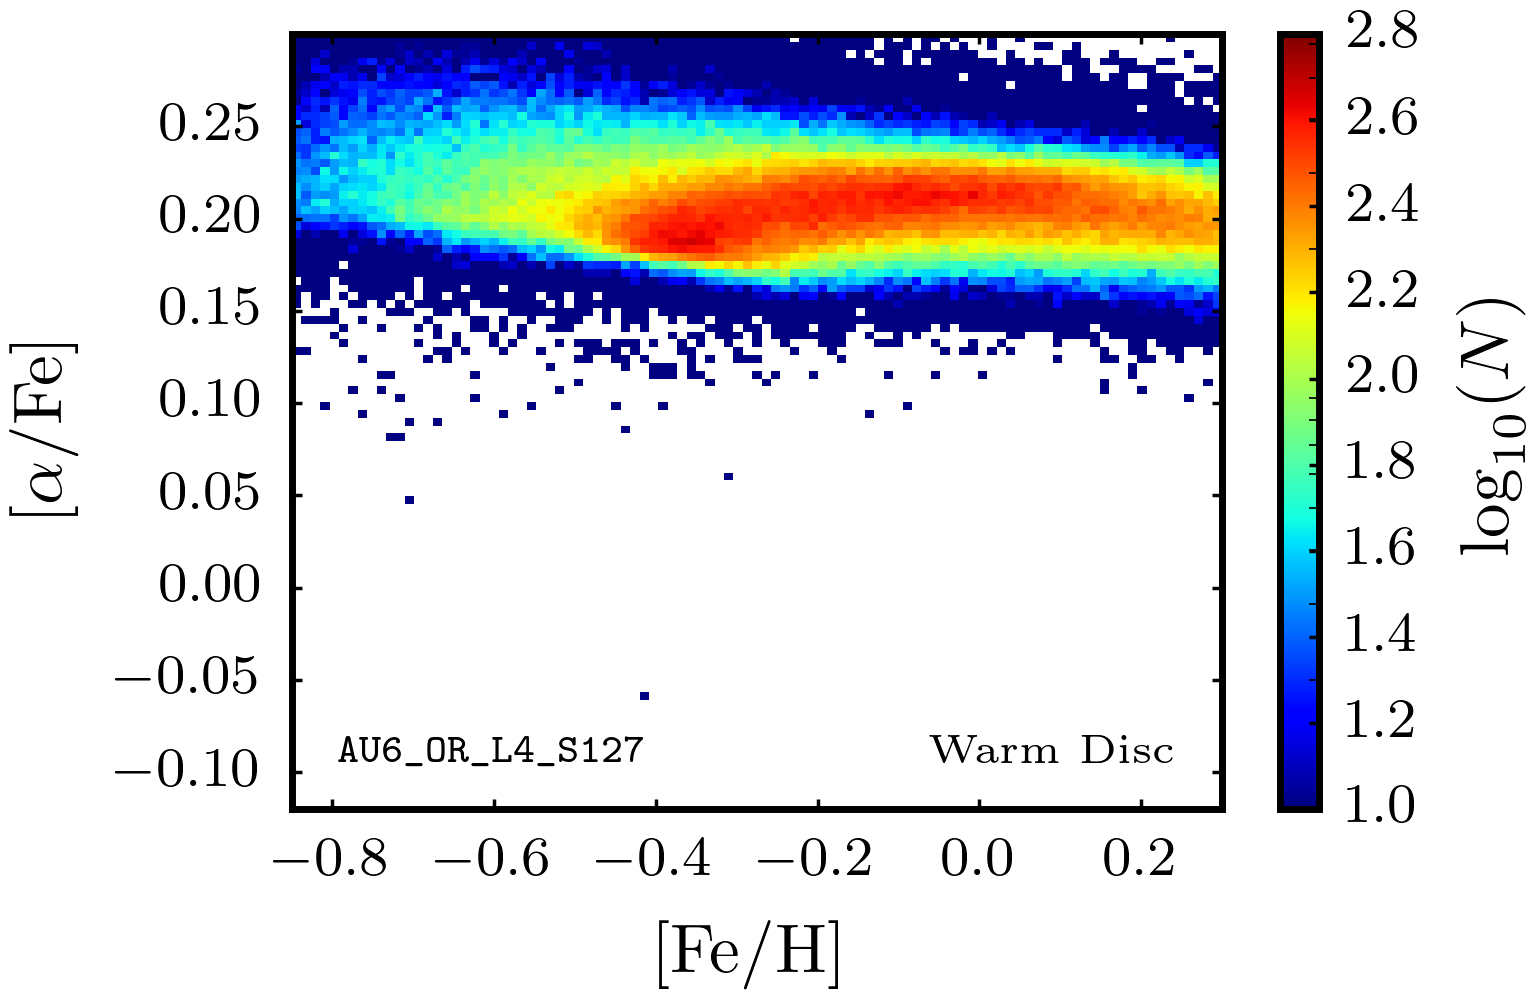

In [49]:
fig = plt.figure(figsize=(3.0, 2.0))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.tick_params(which='both', direction="in")
ax.set_xlim(-0.85, 0.3)
ax.set_ylim(-0.12, 0.3)
ax.set_xticks([-0.8, -0.6, -0.4, -0.2, 0, 0.2])
ax.set_yticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
ax.label_outer()

_, _, _, im = ax.hist2d(
    x=df["[Fe/H]"][(df["RegionTag"] == 3)],
    y=df["[Alpha/Fe]"][(df["RegionTag"] == 3)],
    bins=[np.linspace(-0.85, 0.3, 100), np.linspace(-0.12, 0.3, 100)],
    norm=mpl.colors.LogNorm(vmin=1E1, vmax=10**2.8))

ax.text(
    x=0.05, y=0.05, size=6.0, c="black",
    s=r"$\texttt{" + ("au6_or_l4_s127").upper() + "}$",
    ha="left", va="bottom", transform=ax.transAxes)
ax.text(
    x=0.95, y=0.05, size=6.0, c="black", s="Warm Disc",
    ha="right", va="bottom", transform=ax.transAxes)

cbar = fig.colorbar(im, label=r"$\mathrm{log}_{10}(N)$")
cbar.set_ticks(ticks=(10**1.0, 10**1.2, 10**1.4, 10**1.6, 10**1.8,
                      10**2.0, 10**2.2, 10**2.4, 10**2.6, 10**2.8),
               labels=[1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8])

plt.show()

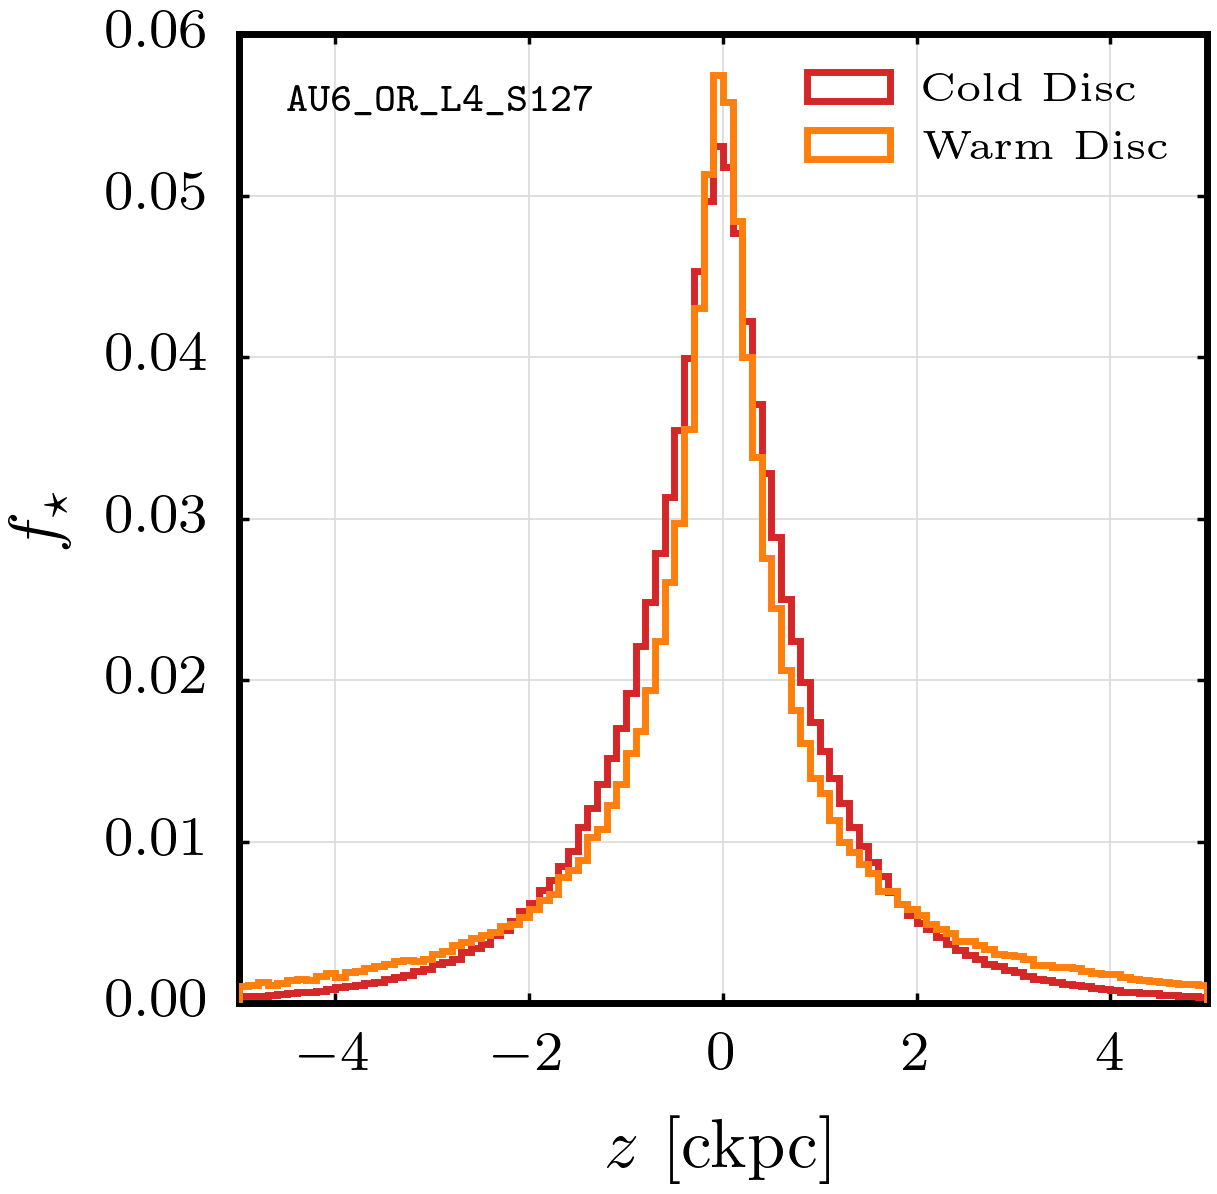

In [103]:
fig = plt.figure(figsize=(2.5, 2.5))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.set_axisbelow(True)
ax.grid(True, ls='-', lw=0.25, c="gainsboro")
ax.tick_params(which='both', direction="in")
ax.set_xlim(-5, 5)
ax.set_xlabel(r"$z$ [ckpc]")
ax.set_ylabel(r"$f_\star$")
ax.label_outer()

ax.hist(
    x=df["zPos_ckpc"][(df["RegionTag"] == 2)],
    weights=np.ones(
        len(df[(df["RegionTag"] == 2)])) / len(df[(df["RegionTag"] == 2)]),
    bins=100, range=ax.get_xlim(), color="tab:red", zorder=10,
    histtype="step", label="Cold Disc")
ax.hist(
    x=df["zPos_ckpc"][(df["RegionTag"] == 3)],
    weights=np.ones(
        len(df[(df["RegionTag"] == 3)])) / len(df[(df["RegionTag"] == 3)]),
    bins=100, range=ax.get_xlim(), color="tab:orange", zorder=10,
    histtype="step", label="Warm Disc")

ax.text(
    x=0.05, y=0.95, size=6.0, c="black",
    s=r"$\texttt{" + ("au6_or_l4_s127").upper() + "}$",
    ha="left", va="top", transform=ax.transAxes)

ax.legend(loc="upper right", framealpha=0, fontsize=6)

plt.show()

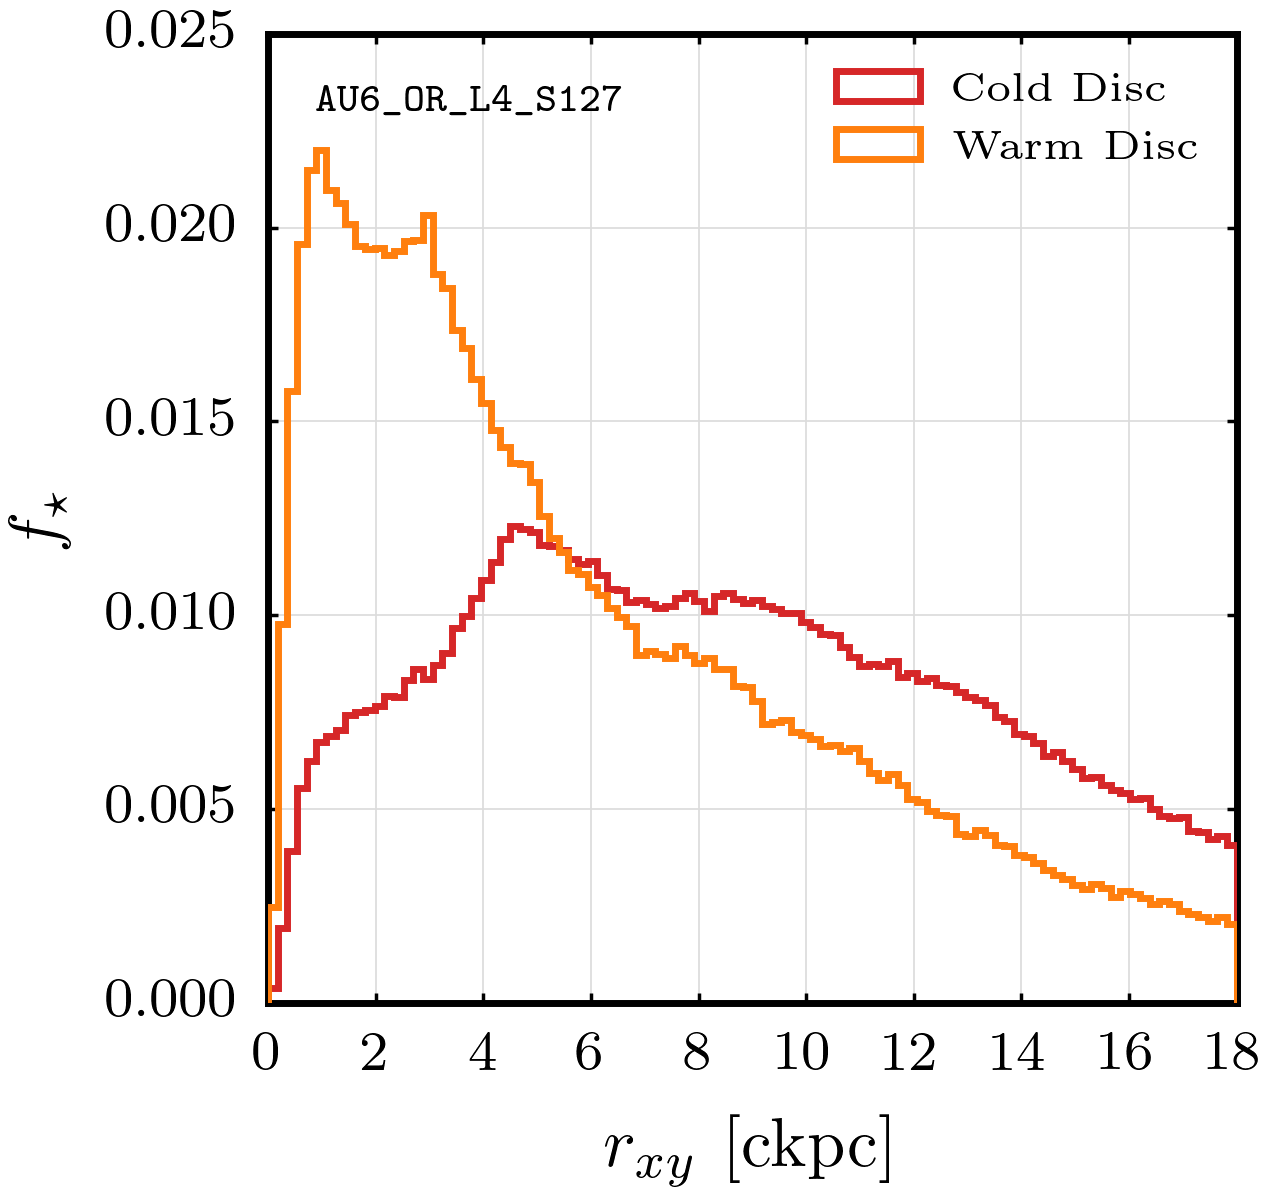

In [105]:
fig = plt.figure(figsize=(2.5, 2.5))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.set_axisbelow(True)
ax.grid(True, ls='-', lw=0.25, c="gainsboro")
ax.tick_params(which='both', direction="in")
ax.set_xlim(0, 18)
ax.set_xlabel(r"$r_{xy}$ [ckpc]")
ax.set_ylabel(r"$f_\star$")
ax.label_outer()

ax.hist(
    x=df["CylindricalRadius_ckpc"][(df["RegionTag"] == 2)],
    weights=np.ones(
        len(df[(df["RegionTag"] == 2)])) / len(df[(df["RegionTag"] == 2)]),
    bins=100, range=ax.get_xlim(), color="tab:red", zorder=10,
    histtype="step", label="Cold Disc")
ax.hist(
    x=df["CylindricalRadius_ckpc"][(df["RegionTag"] == 3)],
    weights=np.ones(
        len(df[(df["RegionTag"] == 3)])) / len(df[(df["RegionTag"] == 3)]),
    bins=100, range=ax.get_xlim(), color="tab:orange", zorder=10,
    histtype="step", label="Warm Disc")

ax.text(
    x=0.05, y=0.95, size=6.0, c="black",
    s=r"$\texttt{" + ("au6_or_l4_s127").upper() + "}$",
    ha="left", va="top", transform=ax.transAxes)

ax.legend(loc="upper right", framealpha=0, fontsize=6)

plt.show()

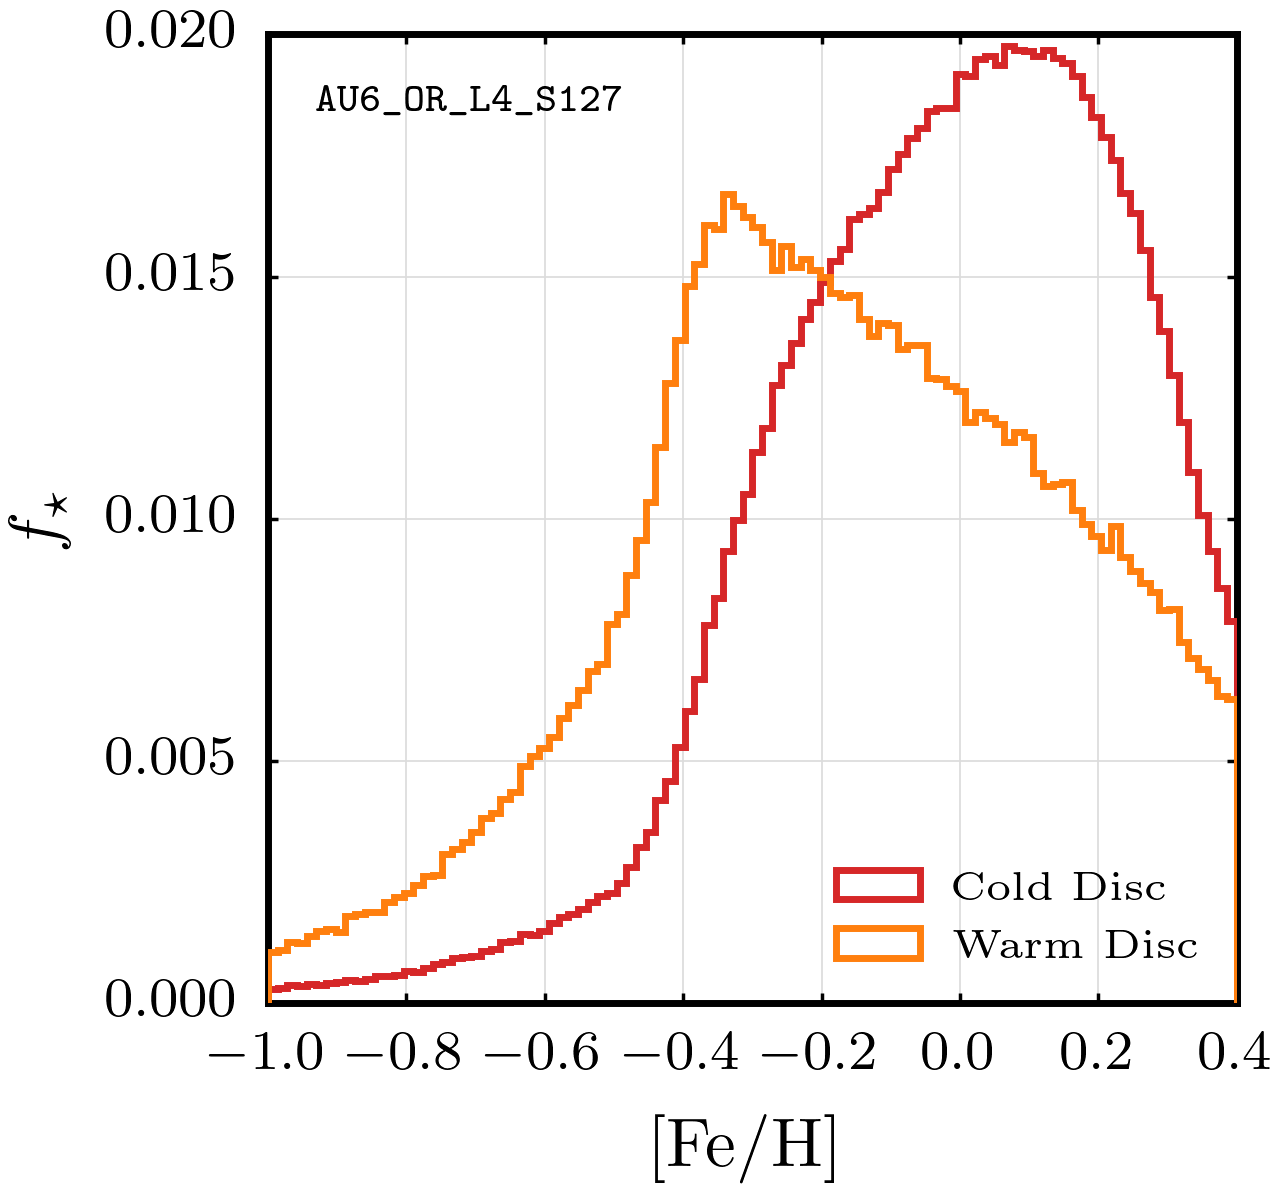

In [107]:
fig = plt.figure(figsize=(2.5, 2.5))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.set_axisbelow(True)
ax.grid(True, ls='-', lw=0.25, c="gainsboro")
ax.tick_params(which='both', direction="in")
ax.set_xlim(-1, 0.4)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"$f_\star$")
ax.label_outer()

ax.hist(
    x=df["[Fe/H]"][(df["RegionTag"] == 2)],
    weights=np.ones(
        len(df[(df["RegionTag"] == 2)])) / len(df[(df["RegionTag"] == 2)]),
    bins=100, range=ax.get_xlim(), color="tab:red", zorder=10,
    histtype="step", label="Cold Disc")
ax.hist(
    x=df["[Fe/H]"][(df["RegionTag"] == 3)],
    weights=np.ones(
        len(df[(df["RegionTag"] == 3)])) / len(df[(df["RegionTag"] == 3)]),
    bins=100, range=ax.get_xlim(), color="tab:orange", zorder=10,
    histtype="step", label="Warm Disc")

ax.text(
    x=0.05, y=0.95, size=6.0, c="black",
    s=r"$\texttt{" + ("au6_or_l4_s127").upper() + "}$",
    ha="left", va="top", transform=ax.transAxes)

ax.legend(loc="lower right", framealpha=0, fontsize=6)

plt.show()

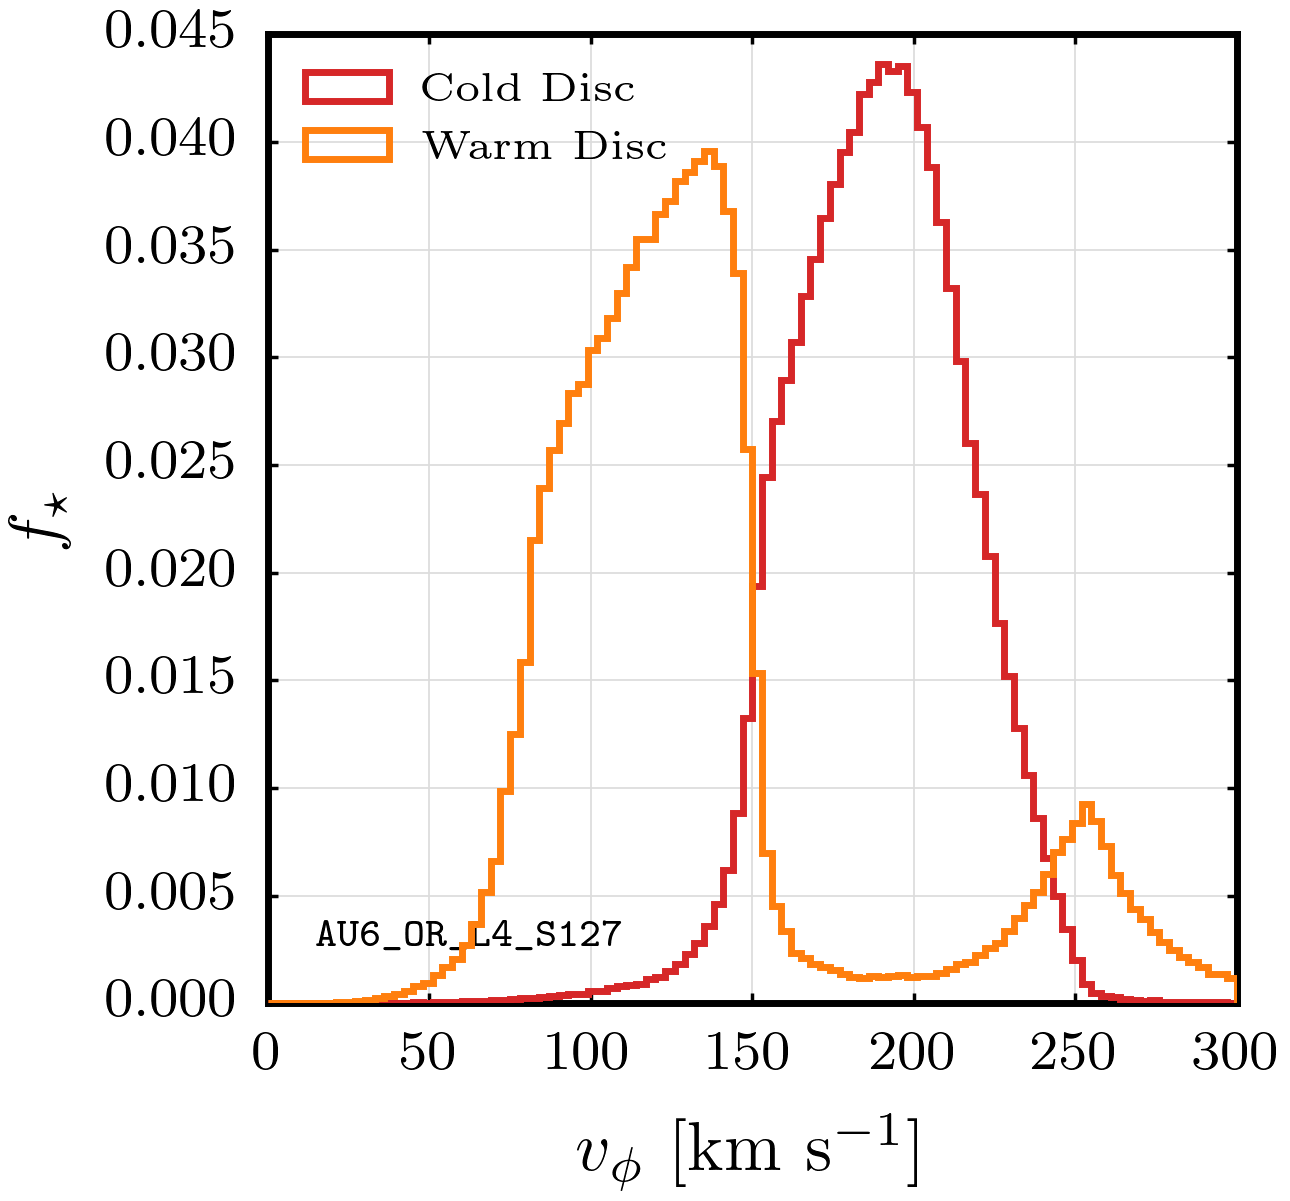

In [113]:
fig = plt.figure(figsize=(2.5, 2.5))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.set_axisbelow(True)
ax.grid(True, ls='-', lw=0.25, c="gainsboro")
ax.tick_params(which='both', direction="in")
ax.set_xlim(0, 300)
ax.set_xlabel(r"$v_\phi$ [$\mathrm{km} ~ \mathrm{s}^{-1}$]")
ax.set_ylabel(r"$f_\star$")
ax.label_outer()

ax.hist(
    x=df["phiVel_km/s"][(df["RegionTag"] == 2)],
    weights=np.ones(
        len(df[(df["RegionTag"] == 2)])) / len(df[(df["RegionTag"] == 2)]),
    bins=100, range=ax.get_xlim(), color="tab:red", zorder=10,
    histtype="step", label="Cold Disc")
ax.hist(
    x=df["phiVel_km/s"][(df["RegionTag"] == 3)],
    weights=np.ones(
        len(df[(df["RegionTag"] == 3)])) / len(df[(df["RegionTag"] == 3)]),
    bins=100, range=ax.get_xlim(), color="tab:orange", zorder=10,
    histtype="step", label="Warm Disc")

ax.text(
    x=0.05, y=0.05, size=6.0, c="black",
    s=r"$\texttt{" + ("au6_or_l4_s127").upper() + "}$",
    ha="left", va="bottom", transform=ax.transAxes)

ax.legend(loc="upper left", framealpha=0, fontsize=6)

plt.show()

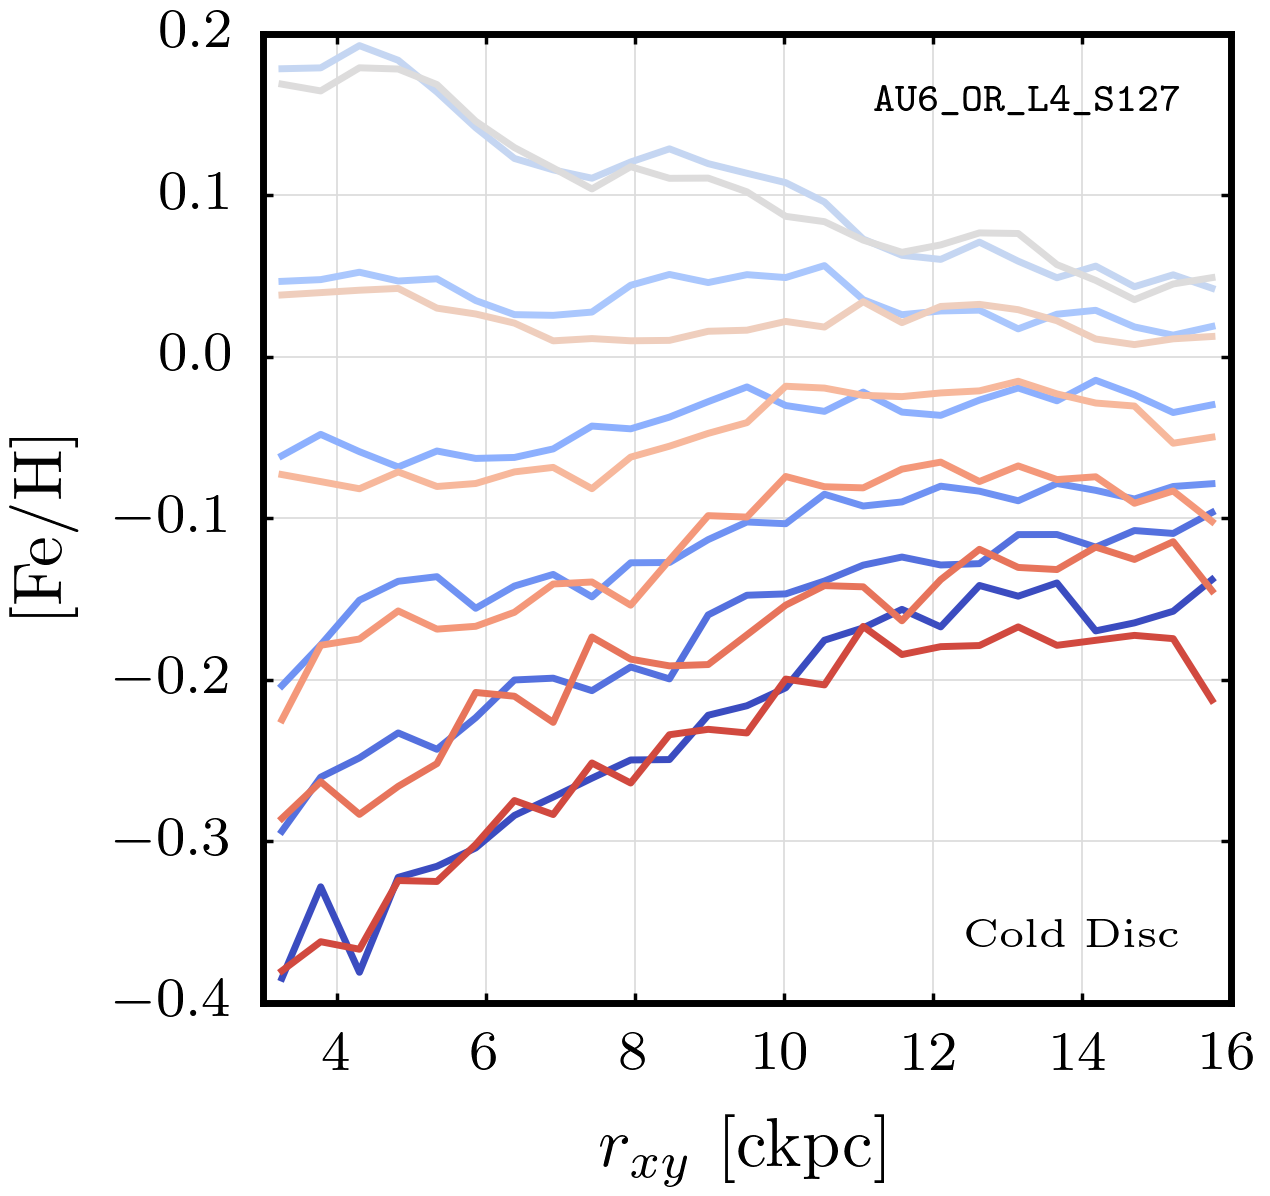

In [117]:
fig = plt.figure(figsize=(2.5, 2.5))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.set_axisbelow(True)
ax.grid(True, ls='-', lw=0.25, c="gainsboro")
ax.tick_params(which='both', direction="in")
ax.set_xlim(3, 16)
ax.set_xlabel(r"$r_{xy}$ [ckpc]")
ax.set_ylabel(r"[Fe/H]")
ax.label_outer()

z_values = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
cmap = plt.cm.coolwarm
for i in range(len(z_values) - 1):
    z_min, z_max = z_values[i], z_values[i + 1]
    cmap_num = (z_min + z_values[-1]) / z_values[-1] / 2
    is_region = (df["RegionTag"] == 2)
    is_z = (df["zPos_ckpc"] >= z_min) & (df["zPos_ckpc"] <= z_max)
    stat, bin_edges, _ = binned_statistic(
        x=df["CylindricalRadius_ckpc"][is_region & is_z],
        values=df["[Fe/H]"][is_region & is_z], bins=25, range=ax.get_xlim())
    bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2
    ax.plot(bin_centers, stat, c=cmap(cmap_num))

ax.text(
    x=0.95, y=0.95, size=6.0, c="black",
    s=r"$\texttt{" + ("au6_or_l4_s127").upper() + "}$",
    ha="right", va="top", transform=ax.transAxes)
ax.text(
    x=0.95, y=0.05, size=6.0, c="black", s="Cold Disc",
    ha="right", va="bottom", transform=ax.transAxes)

plt.show()

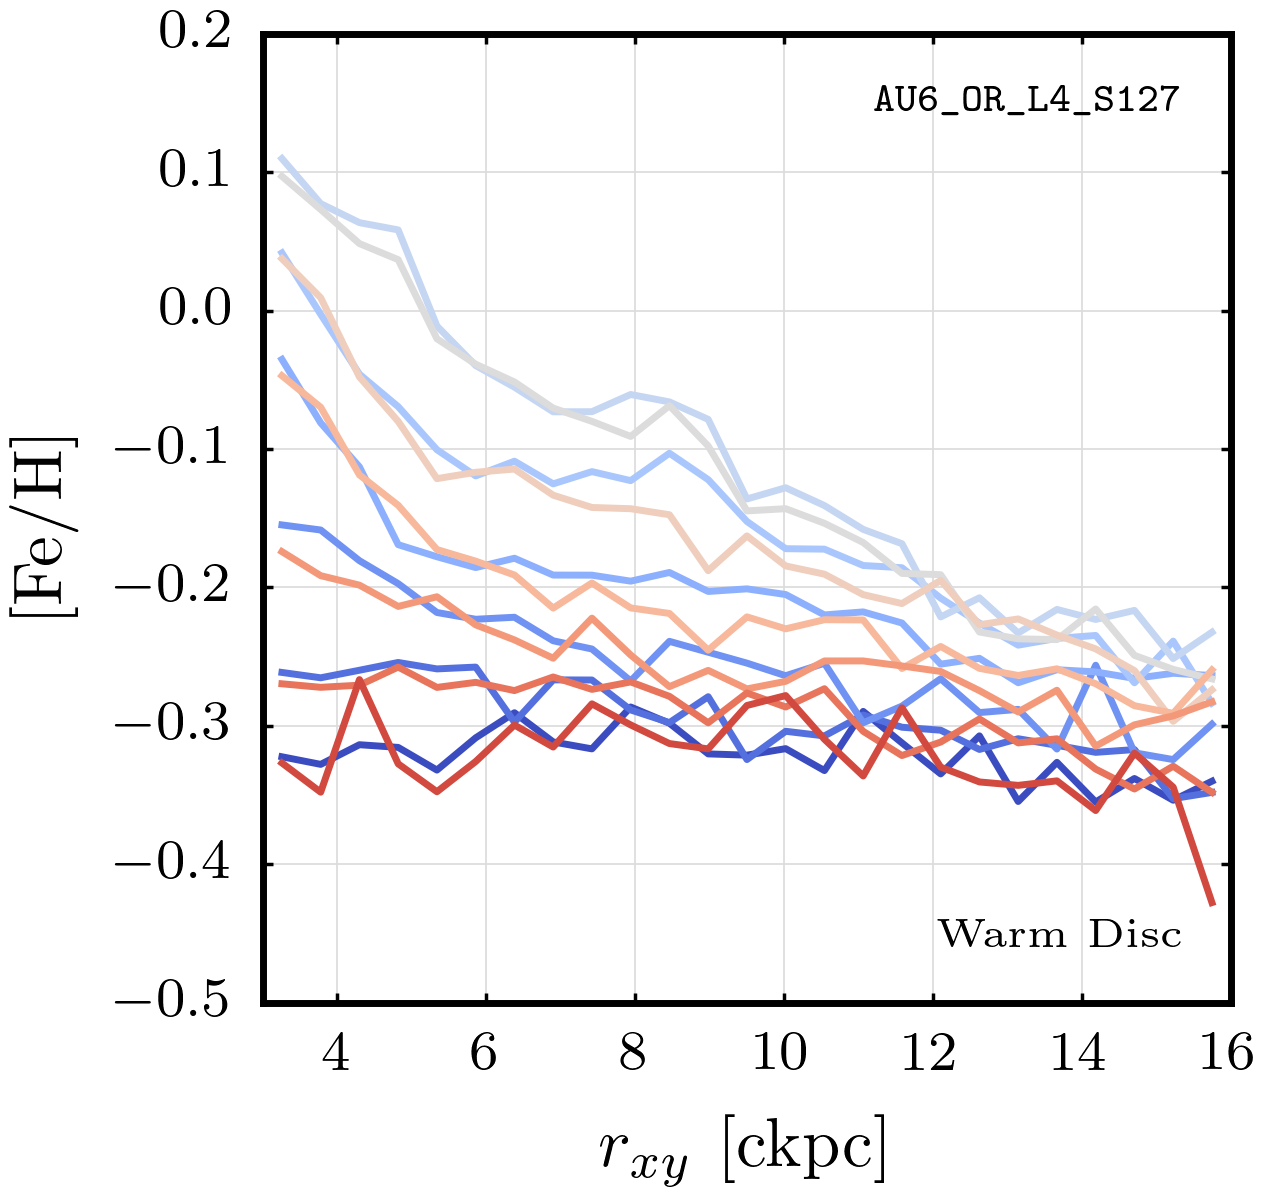

In [118]:
fig = plt.figure(figsize=(2.5, 2.5))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.set_axisbelow(True)
ax.grid(True, ls='-', lw=0.25, c="gainsboro")
ax.tick_params(which='both', direction="in")
ax.set_xlim(3, 16)
ax.set_xlabel(r"$r_{xy}$ [ckpc]")
ax.set_ylabel(r"[Fe/H]")
ax.label_outer()

z_values = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
cmap = plt.cm.coolwarm
for i in range(len(z_values) - 1):
    z_min, z_max = z_values[i], z_values[i + 1]
    cmap_num = (z_min + z_values[-1]) / z_values[-1] / 2
    is_region = (df["RegionTag"] == 3)
    is_z = (df["zPos_ckpc"] >= z_min) & (df["zPos_ckpc"] <= z_max)
    stat, bin_edges, _ = binned_statistic(
        x=df["CylindricalRadius_ckpc"][is_region & is_z],
        values=df["[Fe/H]"][is_region & is_z], bins=25, range=ax.get_xlim())
    bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2
    ax.plot(bin_centers, stat, c=cmap(cmap_num))

ax.text(
    x=0.95, y=0.95, size=6.0, c="black",
    s=r"$\texttt{" + ("au6_or_l4_s127").upper() + "}$",
    ha="right", va="top", transform=ax.transAxes)
ax.text(
    x=0.95, y=0.05, size=6.0, c="black", s="Warm Disc",
    ha="right", va="bottom", transform=ax.transAxes)

plt.show()